# Baseline model using Linear Regression

## Imports

In [1]:
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import root_mean_squared_error
from sklearn import set_config

from utils import PROCESSED_DATA_DIR, VALIDATION_CUTOFF, print_metrics

pl.Config.set_tbl_rows(20)
set_config(transform_output = "pandas")

## Data loading

In [2]:
processed_train_df = pl.read_parquet(
    PROCESSED_DATA_DIR.joinpath('training', 'train_full.parquet')
)

processed_train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8
"""U1""",6143,2018-01-01,2017-11-27,469,35,0,11,null,null,null,null,null,null,null,null,null,null,7,3,1
"""L1""",5927,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 20:33:00,2018-01-01 23:50:00,197,-300,0,5,5,1,1468,360,1,5,0
"""L3""",18075,2018-01-01,2017-11-27,422,35,0,6,2018-01-01 13:20:00,2018-01-01 14:35:00,75,-480,0,3,30,9,6659,228,4,3,0
"""OTH""",2416,2018-01-01,2017-11-27,787,35,0,4,2018-01-01 20:22:00,2018-01-01 21:46:00,84,-480,0,5,30,4,6659,316,3,4,0
"""L3""",18270,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 11:17:00,2018-01-01 12:40:00,83,-480,0,2,30,5,6659,231,3,4,0
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1
"""OTH""",4825,2018-01-01,2017-11-27,432,35,0,6,2018-01-01 12:55:00,2018-01-01 14:07:00,72,-480,0,3,30,9,6659,316,4,3,0
"""OTH""",6175,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 18:55:00,2018-01-01 20:23:00,88,-480,0,4,21,7,6579,354,7,3,0


In [3]:
processed_train_df.describe()

statistic,carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,str,f64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1698818""",1.698818e6,"""1698818""","""1698818""",1.698818e6,1.698818e6,1.698818e6,1.698818e6,"""1599704""","""1599704""",1.599704e6,1.599704e6,1.599704e6,1.599704e6,1.599704e6,1.599704e6,1.598505e6,1.598505e6,1.698818e6,1.698818e6,1.698818e6
"""null_count""","""0""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,"""99114""","""99114""",99114.0,99114.0,99114.0,99114.0,99114.0,99114.0,100313.0,100313.0,0.0,0.0,0.0
"""mean""",null,5910.75087,"""2018-06-24""","""2018-06-07""",710.461822,17.419005,0.695564,5.91818,"""2018-07-01 06:49:28.030135""","""2018-07-01 08:45:02.581152""",115.57585,-405.751189,0.013588,2.93231,23.034132,5.301361,5721.521024,271.993762,3.944983,3.839782,0.058343
"""std""",null,4285.440264,null,null,543.207638,12.959215,0.460168,2.968049,null,null,62.670552,62.255521,0.115774,1.260417,11.898872,2.971523,2358.75767,63.198466,1.690606,1.631242,0.234391
"""min""","""L1""",174.0,"""2018-01-01""","""2017-11-27""",234.0,0.0,0.0,0.0,"""2018-01-01 05:31:00""","""2018-01-01 07:02:00""",60.0,-480.0,0.0,0.0,2.0,1.0,1378.0,165.0,0.0,0.0,0.0
"""25%""",null,2724.0,"""2018-03-30""","""2018-03-12""",395.0,8.0,0.0,4.0,"""2018-04-04 08:05:00""","""2018-04-04 10:37:00""",78.0,-420.0,0.0,2.0,9.0,3.0,2864.0,223.0,3.0,3.0,0.0
"""50%""",null,5280.0,"""2018-06-08""","""2018-05-22""",552.0,16.0,1.0,6.0,"""2018-06-20 06:05:00""","""2018-06-20 07:57:00""",89.0,-420.0,0.0,3.0,22.0,5.0,7022.0,270.0,4.0,3.0,0.0
"""75%""",null,6759.0,"""2018-09-24""","""2018-09-06""",825.0,26.0,1.0,8.0,"""2018-09-29 10:40:00""","""2018-09-29 12:28:00""",106.0,-360.0,0.0,4.0,35.0,8.0,7578.0,308.0,5.0,5.0,0.0
"""max""","""U3""",29555.0,"""2018-12-31""","""2018-12-31""",7859.0,328.0,1.0,11.0,"""2018-12-31 22:52:00""","""2019-01-01 00:26:00""",304.0,-240.0,1.0,5.0,43.0,12.0,8396.0,423.0,7.0,7.0,1.0


In [4]:
train_df = processed_train_df.filter(
    pl.col('flt_departure_dt') <= VALIDATION_CUTOFF
)

train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8
"""U1""",6143,2018-01-01,2017-11-27,469,35,0,11,null,null,null,null,null,null,null,null,null,null,7,3,1
"""L1""",5927,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 20:33:00,2018-01-01 23:50:00,197,-300,0,5,5,1,1468,360,1,5,0
"""L3""",18075,2018-01-01,2017-11-27,422,35,0,6,2018-01-01 13:20:00,2018-01-01 14:35:00,75,-480,0,3,30,9,6659,228,4,3,0
"""OTH""",2416,2018-01-01,2017-11-27,787,35,0,4,2018-01-01 20:22:00,2018-01-01 21:46:00,84,-480,0,5,30,4,6659,316,3,4,0
"""L3""",18270,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 11:17:00,2018-01-01 12:40:00,83,-480,0,2,30,5,6659,231,3,4,0
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1
"""OTH""",4825,2018-01-01,2017-11-27,432,35,0,6,2018-01-01 12:55:00,2018-01-01 14:07:00,72,-480,0,3,30,9,6659,316,4,3,0
"""OTH""",6175,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 18:55:00,2018-01-01 20:23:00,88,-480,0,4,21,7,6579,354,7,3,0


In [5]:
train_df.describe()

statistic,carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,str,f64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1430585""",1.430585e6,"""1430585""","""1430585""",1.430585e6,1.430585e6,1.430585e6,1.430585e6,"""1334286""","""1334286""",1.334286e6,1.334286e6,1.334286e6,1.334286e6,1.334286e6,1.334286e6,1.330272e6,1.330272e6,1.430585e6,1.430585e6,1.430585e6
"""null_count""","""0""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,"""96299""","""96299""",96299.0,96299.0,96299.0,96299.0,96299.0,96299.0,100313.0,100313.0,0.0,0.0,0.0
"""mean""",null,5935.910139,"""2018-05-25""","""2018-05-08""",693.371445,17.24151,0.817043,5.943453,"""2018-05-31 15:40:39.300480""","""2018-05-31 17:36:15.812906""",115.60854,-398.055364,0.013749,2.939778,23.221803,5.333864,5769.208711,272.781796,3.959293,3.83536,0.067314
"""std""",null,4303.897663,null,null,464.029222,12.550131,0.386631,2.967777,null,null,62.478949,60.514975,0.116447,1.264207,11.936927,3.006358,2372.540332,63.577805,1.691466,1.62231,0.250566
"""min""","""L1""",174.0,"""2018-01-01""","""2017-11-27""",234.0,0.0,0.0,0.0,"""2018-01-01 05:31:00""","""2018-01-01 07:02:00""",60.0,-480.0,0.0,0.0,2.0,1.0,1378.0,166.0,0.0,0.0,0.0
"""25%""",null,2727.0,"""2018-03-22""","""2018-03-05""",395.0,8.0,1.0,4.0,"""2018-03-26 21:30:00""","""2018-03-26 23:35:00""",79.0,-420.0,0.0,2.0,9.0,3.0,2864.0,222.0,3.0,3.0,0.0
"""50%""",null,5274.0,"""2018-05-06""","""2018-04-17""",545.0,16.0,1.0,6.0,"""2018-05-16 19:10:00""","""2018-05-16 20:52:00""",90.0,-420.0,0.0,3.0,23.0,5.0,7054.0,276.0,4.0,3.0,0.0
"""75%""",null,6759.0,"""2018-08-05""","""2018-07-19""",812.0,26.0,1.0,8.0,"""2018-08-11 07:00:00""","""2018-08-11 09:09:00""",104.0,-360.0,0.0,4.0,35.0,8.0,7578.0,311.0,5.0,5.0,0.0
"""max""","""U3""",29555.0,"""2018-10-31""","""2018-10-31""",6354.0,328.0,1.0,11.0,"""2018-10-31 22:40:00""","""2018-10-31 23:51:00""",304.0,-240.0,1.0,5.0,43.0,12.0,8396.0,423.0,7.0,7.0,1.0


In [6]:
val_df = processed_train_df.filter(
    (pl.col('flt_departure_dt') > VALIDATION_CUTOFF) & 
    (
        pl.col('flt_departure_dt') <= (VALIDATION_CUTOFF + pl.duration(days = 7))
    )
)

val_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8
"""U1""",6184,2018-11-01,2018-02-14,397,260,1,5,2018-11-01 20:20:00,2018-11-01 22:02:00,102,-420,0,5,23,2,6396,250,3,7,0
"""L1""",2444,2018-11-01,2018-02-14,369,260,1,5,null,null,null,null,null,null,null,null,6396,292,3,7,1
"""U1""",6134,2018-11-01,2018-02-14,425,260,1,5,2018-11-01 10:50:00,2018-11-01 12:33:00,103,-420,0,2,23,5,6396,250,3,7,0
"""L1""",1575,2018-11-01,2018-02-14,416,260,1,5,2018-11-01 11:10:00,2018-11-01 12:46:00,96,-420,0,2,23,5,6396,292,3,7,0
"""L1""",5811,2018-11-01,2018-02-14,564,260,1,5,2018-11-01 15:15:00,2018-11-01 16:49:00,94,-420,0,3,23,6,6396,292,3,7,0
"""L1""",18973,2018-11-01,2018-02-14,717,260,1,5,null,null,null,null,null,null,null,null,6396,292,3,7,1
"""L1""",5675,2018-11-01,2018-02-14,466,260,1,5,2018-11-01 13:17:00,2018-11-01 14:53:00,96,-420,0,3,23,6,6396,292,3,7,0
"""U1""",6153,2018-11-01,2018-02-14,466,260,1,5,2018-11-01 17:20:00,2018-11-01 19:02:00,102,-420,0,4,23,7,6396,250,3,7,0
"""U1""",6178,2018-11-01,2018-02-14,425,260,1,5,2018-11-01 18:30:00,2018-11-01 20:12:00,102,-420,0,4,23,7,6396,250,3,7,0


In [7]:
val_df.describe()

statistic,carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null
str,str,f64,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""29609""",29609.0,"""29609""","""29609""",29609.0,29609.0,29609.0,29609.0,"""29581""","""29581""",29581.0,29581.0,29581.0,29581.0,29581.0,29581.0,29609.0,29609.0,29609.0,29609.0,29609.0
"""null_count""","""0""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,"""28""","""28""",28.0,28.0,28.0,28.0,28.0,28.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,5463.548313,"""2018-11-03""","""2018-10-17""",740.064879,17.77338,0.431828,5.808943,"""2018-11-04 12:42:09.212670""","""2018-11-04 14:37:03.888306""",114.911261,-422.843717,0.011866,2.920388,23.597444,5.444035,5824.798237,265.192104,3.885373,3.874633,0.000946
"""std""",null,3946.994907,null,null,492.803678,16.650847,0.495339,2.927823,null,null,63.526245,61.317732,0.108284,1.244101,12.420585,3.080005,2431.098136,59.276306,1.650032,1.665371,0.030738
"""min""","""L1""",570.0,"""2018-11-01""","""2017-12-13""",263.0,0.0,0.0,0.0,"""2018-11-01 00:55:00""","""2018-11-01 05:49:00""",62.0,-480.0,0.0,0.0,4.0,1.0,1922.0,165.0,0.0,0.0,0.0
"""25%""",null,2388.0,"""2018-11-02""","""2018-10-10""",395.0,8.0,0.0,4.0,"""2018-11-02 16:55:00""","""2018-11-02 18:44:00""",76.0,-480.0,0.0,2.0,9.0,2.0,2838.0,221.0,3.0,3.0,0.0
"""50%""",null,5274.0,"""2018-11-04""","""2018-10-19""",555.0,16.0,0.0,5.0,"""2018-11-04 13:29:00""","""2018-11-04 15:50:00""",85.0,-420.0,0.0,3.0,24.0,5.0,6396.0,252.0,3.0,3.0,0.0
"""75%""",null,6947.0,"""2018-11-06""","""2018-10-27""",957.0,25.0,1.0,7.0,"""2018-11-06 08:06:00""","""2018-11-06 10:15:00""",113.0,-420.0,0.0,4.0,36.0,8.0,8086.0,292.0,5.0,5.0,0.0
"""max""","""U3""",18973.0,"""2018-11-07""","""2018-11-07""",5249.0,325.0,1.0,11.0,"""2018-11-07 22:45:00""","""2018-11-08 00:11:00""",299.0,-240.0,1.0,5.0,39.0,12.0,8086.0,405.0,7.0,7.0,1.0


## Data processing

### Fare rescaling

#### Check if any (`route`, `carrier`) pair is missing in `train_df`

In [8]:
train_df.group_by('route_id', 'carrier').len().drop('len').join(
    val_df.group_by('route_id', 'carrier').len().drop('len'),
    on = ['route_id', 'carrier'],
    how = 'outer'
).null_count()

route_id,carrier,route_id_right,carrier_right
u32,u32,u32,u32
0,0,4,4


#### Calculating range of log of fares by (`route`, `carrier`)

In [9]:
train_df.group_by('route_id', 'carrier').agg(
    (pl.col('total_fare').max() / pl.col('total_fare').mean()).alias('up_range'),
    (pl.col('total_fare').min() / pl.col('total_fare').mean()).alias('down_range')
).describe()

statistic,route_id,carrier,up_range,down_range
str,f64,str,f64,f64
"""count""",34.0,"""34""",34.0,34.0
"""null_count""",0.0,"""0""",0.0,0.0
"""mean""",5.588235,null,4.489822,0.463753
"""std""",3.239132,null,1.980349,0.080049
"""min""",0.0,"""L1""",2.023936,0.280482
"""25%""",3.0,null,2.838609,0.414715
"""50%""",5.0,null,4.24128,0.466559
"""75%""",8.0,null,5.346239,0.521593
"""max""",11.0,"""U3""",9.477622,0.621509


In [10]:
base_fares = train_df.group_by('route_id', 'carrier').agg(
    pl.col('total_fare').log10().mean().alias('base_fare'),
    pl.col('total_fare').log10().std().alias('std_fare'),
    pl.col('total_fare').log10().min().alias('min_fare'),
    pl.col('total_fare').log10().max().alias('max_fare')
).sort('route_id', 'carrier')

base_fares

route_id,carrier,base_fare,std_fare,min_fare,max_fare
u8,str,f64,f64,f64,f64
0,"""L1""",2.87627,0.196102,2.472756,3.764923
0,"""U3""",2.730426,0.140742,2.468347,3.099681
1,"""L1""",2.989814,0.198822,2.638489,3.749659
2,"""L1""",2.933196,0.206151,2.472756,3.725503
2,"""OTH""",2.753779,0.159175,2.448706,3.089905
2,"""U3""",2.701619,0.194855,2.418301,3.237795
3,"""L1""",2.969416,0.216036,2.472756,3.730621
3,"""OTH""",2.75598,0.170682,2.448706,3.111599
3,"""U3""",2.808008,0.214577,2.418301,3.169674


In [11]:
base_fares.select(pl.col(pl.Float64())).describe()

statistic,base_fare,std_fare,min_fare,max_fare
str,f64,f64,f64,f64
"""count""",34.0,34.0,34.0,34.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",2.779038,0.181906,2.481561,3.433907
"""std""",0.131423,0.028898,0.088668,0.257306
"""min""",2.578759,0.119188,2.369216,3.05423
"""25%""",2.668795,0.161205,2.418301,3.24005
"""50%""",2.754933,0.182085,2.472756,3.396548
"""75%""",2.87627,0.205221,2.489958,3.672283
"""max""",3.019574,0.240367,2.669317,3.803047


In [12]:
train_df = train_df.join(
    base_fares.select('route_id', 'carrier', 'base_fare'),
    on = ['route_id', 'carrier'],
    how = 'left'
).with_columns(
    pl.col('total_fare').log10().alias('log_fare')
).with_columns(
    (
        (pl.col('log_fare') - pl.col('base_fare')) / pl.col('base_fare')
    ).round(4).alias('scaled_fare')
)

train_df['scaled_fare'].describe()

statistic,value
str,f64
"""count""",1.430585e6
"""null_count""",0.0
"""mean""",-0.000001
"""std""",0.068372
"""min""",-0.1673
"""25%""",-0.0504
"""50%""",-0.0131
"""75%""",0.0395
"""max""",0.3799


In [13]:
val_df = val_df.join(
    base_fares.select('route_id', 'carrier', 'base_fare'),
    on = ['route_id', 'carrier'],
    how = 'left'
).with_columns(
    pl.col('total_fare').log10().alias('log_fare')
).with_columns(
    (
        (pl.col('log_fare') - pl.col('base_fare')) / pl.col('base_fare')
    ).round(4).alias('scaled_fare')
)

val_df['scaled_fare'].describe()

statistic,value
str,f64
"""count""",29609.0
"""null_count""",0.0
"""mean""",0.004547
"""std""",0.074221
"""min""",-0.1673
"""25%""",-0.0516
"""50%""",-0.0127
"""75%""",0.053
"""max""",0.3573


In [14]:
train_df.sort('scaled_fare')

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64
"""L1""",6523,2018-03-06,2018-02-26,297,8,0,3,2018-03-06 06:00:00,2018-03-06 10:58:00,298,-480,0,1,8,1,2873,392,3,2,0,2.969416,2.472756,-0.1673
"""L1""",6523,2018-03-06,2018-02-27,297,7,0,3,2018-03-06 06:00:00,2018-03-06 10:58:00,298,-480,0,1,8,1,2873,392,3,2,0,2.969416,2.472756,-0.1673
"""L1""",5663,2018-03-09,2018-02-25,297,12,0,3,2018-03-09 12:17:00,2018-03-09 17:16:00,299,-480,0,3,8,3,2873,392,3,2,0,2.969416,2.472756,-0.1673
"""L1""",5663,2018-03-09,2018-02-26,297,11,0,3,2018-03-09 12:17:00,2018-03-09 17:16:00,299,-480,0,3,8,3,2873,392,3,2,0,2.969416,2.472756,-0.1673
"""L1""",3861,2018-03-10,2018-02-23,297,15,0,3,2018-03-10 15:55:00,2018-03-10 20:52:00,297,-480,0,3,8,3,2873,392,3,2,0,2.969416,2.472756,-0.1673
"""L1""",5663,2018-03-10,2018-02-23,297,15,0,3,2018-03-10 12:17:00,2018-03-10 17:16:00,299,-480,0,3,8,3,2873,392,3,2,0,2.969416,2.472756,-0.1673
"""L1""",6523,2018-03-10,2018-02-23,297,15,0,3,2018-03-10 06:05:00,2018-03-10 11:03:00,298,-480,0,1,8,1,2873,392,3,2,0,2.969416,2.472756,-0.1673
"""L1""",6294,2018-03-10,2018-02-23,297,15,0,3,2018-03-10 13:45:00,2018-03-10 18:43:00,298,-480,0,3,8,3,2873,392,3,2,0,2.969416,2.472756,-0.1673
"""L1""",6523,2018-03-10,2018-02-24,297,14,0,3,2018-03-10 06:05:00,2018-03-10 11:03:00,298,-480,0,1,8,1,2873,392,3,2,0,2.969416,2.472756,-0.1673


In [15]:
val_df.sort('scaled_fare')

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64
"""L1""",2149,2018-11-06,2018-10-10,297,27,0,3,2018-11-06 01:00:00,2018-11-06 05:54:00,294,-480,0,0,8,2,2838,405,3,2,0,2.969416,2.472756,-0.1673
"""L1""",2149,2018-11-06,2018-10-11,297,26,0,3,2018-11-06 01:00:00,2018-11-06 05:54:00,294,-480,0,0,8,2,2838,405,3,2,0,2.969416,2.472756,-0.1673
"""L1""",2149,2018-11-06,2018-10-12,297,25,0,3,2018-11-06 01:00:00,2018-11-06 05:54:00,294,-480,0,0,8,2,2838,405,3,2,0,2.969416,2.472756,-0.1673
"""L1""",2149,2018-11-06,2018-10-13,297,24,0,3,2018-11-06 01:00:00,2018-11-06 05:54:00,294,-480,0,0,8,2,2838,405,3,2,0,2.969416,2.472756,-0.1673
"""L1""",2149,2018-11-07,2018-09-26,297,42,0,3,2018-11-07 01:00:00,2018-11-07 05:54:00,294,-480,0,0,8,2,2838,405,3,2,0,2.969416,2.472756,-0.1673
"""L1""",2149,2018-11-07,2018-10-05,297,33,0,3,2018-11-07 01:00:00,2018-11-07 05:54:00,294,-480,0,0,8,2,2838,405,3,2,0,2.969416,2.472756,-0.1673
"""L1""",2149,2018-11-07,2018-10-10,297,28,0,3,2018-11-07 01:00:00,2018-11-07 05:54:00,294,-480,0,0,8,2,2838,405,3,2,0,2.969416,2.472756,-0.1673
"""L1""",2149,2018-11-07,2018-10-11,297,27,0,3,2018-11-07 01:00:00,2018-11-07 05:54:00,294,-480,0,0,8,2,2838,405,3,2,0,2.969416,2.472756,-0.1673
"""L1""",2149,2018-11-07,2018-10-12,297,26,0,3,2018-11-07 01:00:00,2018-11-07 05:54:00,294,-480,0,0,8,2,2838,405,3,2,0,2.969416,2.472756,-0.1673


#### Metrics when predicting `base_fare`

In [16]:
print_metrics(
    train_df['total_fare'], train_df.select(pl.lit(10).pow('base_fare')),
    label = 'Train - Mean Baseline'
)

print_metrics(
    val_df['total_fare'], val_df.select(pl.lit(10).pow('base_fare')),
    label = 'Val - Mean Baseline'
)

Train - Mean Baseline
RMSE: 418.2143
MAE: 253.7485
R2: 18.772%

Val - Mean Baseline
RMSE: 450.3763
MAE: 291.5783
R2: 16.475%



### Feature generation

#### Days since start

In [17]:
train_df = train_df.with_columns(
    (
        pl.col('flt_departure_dt') - train_df['flt_departure_dt'].min()
    ).dt.total_days().alias("days_since_start")
)

train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,days_since_start
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,i64
"""U1""",6143,2018-01-01,2017-11-27,469,35,0,11,null,null,null,null,null,null,null,null,null,null,7,3,1,2.75394,2.671173,-0.0301,0
"""L1""",5927,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 20:33:00,2018-01-01 23:50:00,197,-300,0,5,5,1,1468,360,1,5,0,2.989814,3.04883,0.0197,0
"""L3""",18075,2018-01-01,2017-11-27,422,35,0,6,2018-01-01 13:20:00,2018-01-01 14:35:00,75,-480,0,3,30,9,6659,228,4,3,0,2.729752,2.625312,-0.0383,0
"""OTH""",2416,2018-01-01,2017-11-27,787,35,0,4,2018-01-01 20:22:00,2018-01-01 21:46:00,84,-480,0,5,30,4,6659,316,3,4,0,2.589536,2.895975,0.1183,0
"""L3""",18270,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 11:17:00,2018-01-01 12:40:00,83,-480,0,2,30,5,6659,231,3,4,0,2.754933,3.113275,0.1301,0
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0,2.764942,2.570543,-0.0703,0
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1,2.637849,2.710117,0.0274,0
"""OTH""",4825,2018-01-01,2017-11-27,432,35,0,6,2018-01-01 12:55:00,2018-01-01 14:07:00,72,-480,0,3,30,9,6659,316,4,3,0,2.578759,2.635484,0.022,0
"""OTH""",6175,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 18:55:00,2018-01-01 20:23:00,88,-480,0,4,21,7,6579,354,7,3,0,2.72979,2.532754,-0.0722,0


In [18]:
val_df = val_df.with_columns(
    (
        pl.col('flt_departure_dt') - train_df['flt_departure_dt'].min()
    ).dt.total_days().alias("days_since_start")
)

val_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,days_since_start
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,i64
"""U1""",6184,2018-11-01,2018-02-14,397,260,1,5,2018-11-01 20:20:00,2018-11-01 22:02:00,102,-420,0,5,23,2,6396,250,3,7,0,2.794668,2.598791,-0.0701,304
"""L1""",2444,2018-11-01,2018-02-14,369,260,1,5,null,null,null,null,null,null,null,null,6396,292,3,7,1,2.795584,2.567026,-0.0818,304
"""U1""",6134,2018-11-01,2018-02-14,425,260,1,5,2018-11-01 10:50:00,2018-11-01 12:33:00,103,-420,0,2,23,5,6396,250,3,7,0,2.794668,2.628389,-0.0595,304
"""L1""",1575,2018-11-01,2018-02-14,416,260,1,5,2018-11-01 11:10:00,2018-11-01 12:46:00,96,-420,0,2,23,5,6396,292,3,7,0,2.795584,2.619093,-0.0631,304
"""L1""",5811,2018-11-01,2018-02-14,564,260,1,5,2018-11-01 15:15:00,2018-11-01 16:49:00,94,-420,0,3,23,6,6396,292,3,7,0,2.795584,2.751279,-0.0158,304
"""L1""",18973,2018-11-01,2018-02-14,717,260,1,5,null,null,null,null,null,null,null,null,6396,292,3,7,1,2.795584,2.855519,0.0214,304
"""L1""",5675,2018-11-01,2018-02-14,466,260,1,5,2018-11-01 13:17:00,2018-11-01 14:53:00,96,-420,0,3,23,6,6396,292,3,7,0,2.795584,2.668386,-0.0455,304
"""U1""",6153,2018-11-01,2018-02-14,466,260,1,5,2018-11-01 17:20:00,2018-11-01 19:02:00,102,-420,0,4,23,7,6396,250,3,7,0,2.794668,2.668386,-0.0452,304
"""U1""",6178,2018-11-01,2018-02-14,425,260,1,5,2018-11-01 18:30:00,2018-11-01 20:12:00,102,-420,0,4,23,7,6396,250,3,7,0,2.794668,2.628389,-0.0595,304


#### Flight date features

In [19]:
train_df = train_df.with_columns(
    pl.col('flt_departure_dt').dt.month().alias('flt_departure_month'),
    pl.col('flt_departure_dt').dt.day().alias('flt_departure_day'),
    pl.col('flt_departure_dt').dt.week().alias('flt_departure_week'),    
    pl.col('flt_departure_dt').dt.weekday().alias('flt_departure_weekday')  
)
train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,i64,i8,i8,i8,i8
"""U1""",6143,2018-01-01,2017-11-27,469,35,0,11,null,null,null,null,null,null,null,null,null,null,7,3,1,2.75394,2.671173,-0.0301,0,1,1,1,1
"""L1""",5927,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 20:33:00,2018-01-01 23:50:00,197,-300,0,5,5,1,1468,360,1,5,0,2.989814,3.04883,0.0197,0,1,1,1,1
"""L3""",18075,2018-01-01,2017-11-27,422,35,0,6,2018-01-01 13:20:00,2018-01-01 14:35:00,75,-480,0,3,30,9,6659,228,4,3,0,2.729752,2.625312,-0.0383,0,1,1,1,1
"""OTH""",2416,2018-01-01,2017-11-27,787,35,0,4,2018-01-01 20:22:00,2018-01-01 21:46:00,84,-480,0,5,30,4,6659,316,3,4,0,2.589536,2.895975,0.1183,0,1,1,1,1
"""L3""",18270,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 11:17:00,2018-01-01 12:40:00,83,-480,0,2,30,5,6659,231,3,4,0,2.754933,3.113275,0.1301,0,1,1,1,1
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93,-480,0,4,21,7,6579,262,7,3,0,2.764942,2.570543,-0.0703,0,1,1,1,1
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,null,null,null,null,null,null,null,null,3,4,1,2.637849,2.710117,0.0274,0,1,1,1,1
"""OTH""",4825,2018-01-01,2017-11-27,432,35,0,6,2018-01-01 12:55:00,2018-01-01 14:07:00,72,-480,0,3,30,9,6659,316,4,3,0,2.578759,2.635484,0.022,0,1,1,1,1
"""OTH""",6175,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 18:55:00,2018-01-01 20:23:00,88,-480,0,4,21,7,6579,354,7,3,0,2.72979,2.532754,-0.0722,0,1,1,1,1


In [20]:
val_df = val_df.with_columns(
    pl.col('flt_departure_dt').dt.month().alias('flt_departure_month'),
    pl.col('flt_departure_dt').dt.day().alias('flt_departure_day'),
    pl.col('flt_departure_dt').dt.week().alias('flt_departure_week'),    
    pl.col('flt_departure_dt').dt.weekday().alias('flt_departure_weekday')  
)
val_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],i16,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,i64,i8,i8,i8,i8
"""U1""",6184,2018-11-01,2018-02-14,397,260,1,5,2018-11-01 20:20:00,2018-11-01 22:02:00,102,-420,0,5,23,2,6396,250,3,7,0,2.794668,2.598791,-0.0701,304,11,1,44,4
"""L1""",2444,2018-11-01,2018-02-14,369,260,1,5,null,null,null,null,null,null,null,null,6396,292,3,7,1,2.795584,2.567026,-0.0818,304,11,1,44,4
"""U1""",6134,2018-11-01,2018-02-14,425,260,1,5,2018-11-01 10:50:00,2018-11-01 12:33:00,103,-420,0,2,23,5,6396,250,3,7,0,2.794668,2.628389,-0.0595,304,11,1,44,4
"""L1""",1575,2018-11-01,2018-02-14,416,260,1,5,2018-11-01 11:10:00,2018-11-01 12:46:00,96,-420,0,2,23,5,6396,292,3,7,0,2.795584,2.619093,-0.0631,304,11,1,44,4
"""L1""",5811,2018-11-01,2018-02-14,564,260,1,5,2018-11-01 15:15:00,2018-11-01 16:49:00,94,-420,0,3,23,6,6396,292,3,7,0,2.795584,2.751279,-0.0158,304,11,1,44,4
"""L1""",18973,2018-11-01,2018-02-14,717,260,1,5,null,null,null,null,null,null,null,null,6396,292,3,7,1,2.795584,2.855519,0.0214,304,11,1,44,4
"""L1""",5675,2018-11-01,2018-02-14,466,260,1,5,2018-11-01 13:17:00,2018-11-01 14:53:00,96,-420,0,3,23,6,6396,292,3,7,0,2.795584,2.668386,-0.0455,304,11,1,44,4
"""U1""",6153,2018-11-01,2018-02-14,466,260,1,5,2018-11-01 17:20:00,2018-11-01 19:02:00,102,-420,0,4,23,7,6396,250,3,7,0,2.794668,2.668386,-0.0452,304,11,1,44,4
"""U1""",6178,2018-11-01,2018-02-14,425,260,1,5,2018-11-01 18:30:00,2018-11-01 20:12:00,102,-420,0,4,23,7,6396,250,3,7,0,2.794668,2.628389,-0.0595,304,11,1,44,4


### Imputation

#### Null counts

In [21]:
train_df.null_count()

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,96299,96299,96299,96299,96299,96299,96299,96299,100313,100313,0,0,0,0,0,0,0,0,0,0,0


In [22]:
val_df.null_count()

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,28,28,28,28,28,28,28,28,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Flight duration

In [23]:
mean_durations = train_df.group_by('route_id', 'carrier').agg(
    pl.col('dur_min').mean().round(2).alias("dur_mean"),
    pl.col('dur_min').std().round(2).alias("dur_std")
).sort('route_id', 'carrier')

mean_durations

route_id,carrier,dur_mean,dur_std
u8,str,f64,f64
0,"""L1""",191.37,5.19
0,"""U3""",193.94,3.58
1,"""L1""",187.97,14.84
2,"""L1""",77.15,7.87
2,"""OTH""",72.73,7.93
2,"""U3""",94.24,1.8
3,"""L1""",297.2,3.41
3,"""OTH""",297.12,2.19
3,"""U3""",301.47,1.35


In [24]:
train_df = train_df.join(
    mean_durations.drop('dur_std'),
    on = ['route_id', 'carrier'],
    how = 'left'
).with_columns(
    pl.coalesce(['dur_min', 'dur_mean'])
)

train_df['dur_min'].null_count()

0

In [25]:
val_df = val_df.join(
    mean_durations.drop('dur_std'),
    on = ['route_id', 'carrier'],
    how = 'left'
).with_columns(
    pl.coalesce(['dur_min', 'dur_mean'])
)

val_df['dur_min'].null_count()

0

### Training datasets

In [26]:
TRAINING_COLS = [
    'carrier', 'days_till_flight', 'origin_id', 'destination_id', 
    'dur_min', 'flt_info_null', 'days_since_start', 'is_dst',
    'flt_departure_month', 'flt_departure_day',
    'flt_departure_week', 'flt_departure_weekday'
]

X_train = train_df.select(TRAINING_COLS)
X_val = val_df.select(TRAINING_COLS)

y_train = train_df['scaled_fare']
y_val = val_df['scaled_fare']

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1430585, 12), (29609, 12), (1430585,), (29609,))

## Modelling

### Training

In [27]:
pred_fare_expr = pl.lit(10).pow(
    (pl.col('pred_scaled_fare') * pl.col('base_fare')) + pl.col('base_fare')
).alias('pred_fare')

def get_model():
    col_transform = ColumnTransformer(
        [
            (
                'scaler', 
                StandardScaler(),
                [
                    'days_till_flight', 'dur_min', 'days_since_start', 
                    'flt_departure_month', 'flt_departure_day',
                    'flt_departure_week', 'flt_departure_weekday'
                ]
            ),
            (
                'ohe', 
                OneHotEncoder(drop = 'first', sparse_output = False),
                ['carrier', 'origin_id', 'destination_id']
            )
        ],
        remainder = 'passthrough',
        sparse_threshold = 0
    )

    return Pipeline(
        [
            ('col_transformer', col_transform),
            ('ridge', Ridge())
        ]
    )

def train_model(param_grid, n_iter = 5):
    param_sampler = ParameterSampler(
        param_grid,
        n_iter = n_iter,
        random_state = 7
    )

    best_rmse = float('inf')
    best_model = None
    best_params = None

    for i, params in enumerate(list(param_sampler)):
        model = get_model()
        model.set_params(**params)
        model.fit(X_train, y_train)

        val_preds = val_df.with_columns(
            pred_scaled_fare = model.predict(X_val)
        ).with_columns(pred_fare_expr)['pred_fare']

        rmse = root_mean_squared_error(val_df['total_fare'], val_preds)
        print(f"{i} : {rmse:.3f}")
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_params = params

    print(f"Best params:\n{best_params}")
    return best_model

param_grid = {
    "ridge__alpha": [1_000.0, 100.0, 10.0, 1.0, 0.1, 0.01, 0.001]
}

best_model = train_model(param_grid)
best_model

0 : 407.257
1 : 406.977
2 : 408.753
3 : 406.977
4 : 407.012
Best params:
{'ridge__alpha': 0.001}


Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('scaler', StandardScaler(),
                                                  ['days_till_flight',
                                                   'dur_min',
                                                   'days_since_start',
                                                   'flt_departure_month',
                                                   'flt_departure_day',
                                                   'flt_departure_week',
                                                   'flt_departure_weekday']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['carrier', 'origin_id',
                                                   'destination_id'])])),
                ('ridge', Ridge(alpha=0.001))])

### Predictions

In [28]:
train_df = train_df.with_columns(
    pred_scaled_fare = best_model.predict(X_train)
).with_columns(pred_fare_expr)

train_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday,dur_mean,pred_scaled_fare,pred_fare
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],f64,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,i64,i8,i8,i8,i8,f64,f64,f64
"""U1""",6143,2018-01-01,2017-11-27,469,35,0,11,null,null,94.73,null,null,null,null,null,null,null,7,3,1,2.75394,2.671173,-0.0301,0,1,1,1,1,94.73,-0.061269,384.776178
"""L1""",5927,2018-01-01,2017-11-27,1119,35,0,1,2018-01-01 20:33:00,2018-01-01 23:50:00,197.0,-300,0,5,5,1,1468,360,1,5,0,2.989814,3.04883,0.0197,0,1,1,1,1,187.97,-0.055727,665.581671
"""L3""",18075,2018-01-01,2017-11-27,422,35,0,6,2018-01-01 13:20:00,2018-01-01 14:35:00,75.0,-480,0,3,30,9,6659,228,4,3,0,2.729752,2.625312,-0.0383,0,1,1,1,1,78.68,-0.061617,364.378459
"""OTH""",2416,2018-01-01,2017-11-27,787,35,0,4,2018-01-01 20:22:00,2018-01-01 21:46:00,84.0,-480,0,5,30,4,6659,316,3,4,0,2.589536,2.895975,0.1183,0,1,1,1,1,81.99,-0.056244,277.901544
"""L3""",18270,2018-01-01,2017-11-27,1298,35,0,4,2018-01-01 11:17:00,2018-01-01 12:40:00,83.0,-480,0,2,30,5,6659,231,3,4,0,2.754933,3.113275,0.1301,0,1,1,1,1,79.35,-0.060344,387.872696
"""L1""",1396,2018-01-01,2017-11-27,372,35,0,11,2018-01-01 19:35:00,2018-01-01 21:08:00,93.0,-480,0,4,21,7,6579,262,7,3,0,2.764942,2.570543,-0.0703,0,1,1,1,1,95.68,-0.062591,390.735481
"""U1""",4771,2018-01-01,2017-11-27,513,35,0,4,null,null,80.87,null,null,null,null,null,null,null,3,4,1,2.637849,2.710117,0.0274,0,1,1,1,1,80.87,-0.062181,297.732411
"""OTH""",4825,2018-01-01,2017-11-27,432,35,0,6,2018-01-01 12:55:00,2018-01-01 14:07:00,72.0,-480,0,3,30,9,6659,316,4,3,0,2.578759,2.635484,0.022,0,1,1,1,1,71.43,-0.060248,265.090431
"""OTH""",6175,2018-01-01,2017-11-27,341,35,0,11,2018-01-01 18:55:00,2018-01-01 20:23:00,88.0,-480,0,4,21,7,6579,354,7,3,0,2.72979,2.532754,-0.0722,0,1,1,1,1,90.69,-0.062065,363.382992


In [29]:
val_df = val_df.with_columns(
    pred_scaled_fare = best_model.predict(X_val)
).with_columns(pred_fare_expr)

val_df

carrier,flt_num,flt_departure_dt,observation_date,total_fare,days_till_flight,is_dst,route_id,flt_departure_local_time,flt_arrival_local_time,dur_min,tz_min,over_mn,dpt_4h_od,flt_count_dpt_24h,flt_count_dpt_4h,scaled_demand,scaled_share,origin_id,destination_id,flt_info_null,base_fare,log_fare,scaled_fare,days_since_start,flt_departure_month,flt_departure_day,flt_departure_week,flt_departure_weekday,dur_mean,pred_scaled_fare,pred_fare
str,i64,date,date,i64,i16,i8,u8,datetime[ns],datetime[ns],f64,i16,i8,i8,u8,u8,i64,i64,u8,u8,u8,f64,f64,f64,i64,i8,i8,i8,i8,f64,f64,f64
"""U1""",6184,2018-11-01,2018-02-14,397,260,1,5,2018-11-01 20:20:00,2018-11-01 22:02:00,102.0,-420,0,5,23,2,6396,250,3,7,0,2.794668,2.598791,-0.0701,304,11,1,44,4,97.77,-0.440932,36.509825
"""L1""",2444,2018-11-01,2018-02-14,369,260,1,5,null,null,97.69,null,null,null,null,null,6396,292,3,7,1,2.795584,2.567026,-0.0818,304,11,1,44,4,97.69,-0.441699,36.372754
"""U1""",6134,2018-11-01,2018-02-14,425,260,1,5,2018-11-01 10:50:00,2018-11-01 12:33:00,103.0,-420,0,2,23,5,6396,250,3,7,0,2.794668,2.628389,-0.0595,304,11,1,44,4,97.77,-0.440249,36.670605
"""L1""",1575,2018-11-01,2018-02-14,416,260,1,5,2018-11-01 11:10:00,2018-11-01 12:46:00,96.0,-420,0,2,23,5,6396,292,3,7,0,2.795584,2.619093,-0.0631,304,11,1,44,4,97.69,-0.444011,35.835482
"""L1""",5811,2018-11-01,2018-02-14,564,260,1,5,2018-11-01 15:15:00,2018-11-01 16:49:00,94.0,-420,0,3,23,6,6396,292,3,7,0,2.795584,2.751279,-0.0158,304,11,1,44,4,97.69,-0.445377,35.52183
"""L1""",18973,2018-11-01,2018-02-14,717,260,1,5,null,null,97.69,null,null,null,null,null,6396,292,3,7,1,2.795584,2.855519,0.0214,304,11,1,44,4,97.69,-0.441699,36.372754
"""L1""",5675,2018-11-01,2018-02-14,466,260,1,5,2018-11-01 13:17:00,2018-11-01 14:53:00,96.0,-420,0,3,23,6,6396,292,3,7,0,2.795584,2.668386,-0.0455,304,11,1,44,4,97.69,-0.444011,35.835482
"""U1""",6153,2018-11-01,2018-02-14,466,260,1,5,2018-11-01 17:20:00,2018-11-01 19:02:00,102.0,-420,0,4,23,7,6396,250,3,7,0,2.794668,2.668386,-0.0452,304,11,1,44,4,97.77,-0.440932,36.509825
"""U1""",6178,2018-11-01,2018-02-14,425,260,1,5,2018-11-01 18:30:00,2018-11-01 20:12:00,102.0,-420,0,4,23,7,6396,250,3,7,0,2.794668,2.628389,-0.0595,304,11,1,44,4,97.77,-0.440932,36.509825


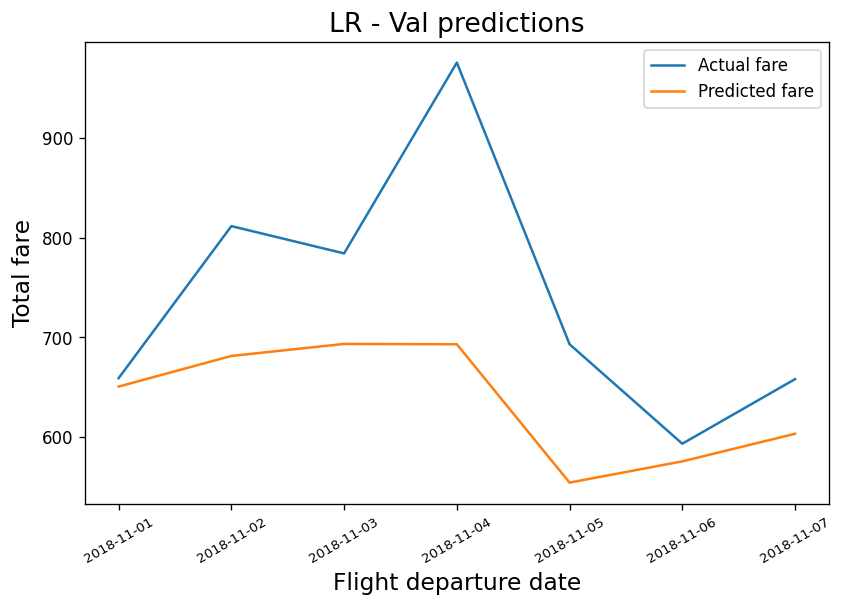

In [30]:
plt.figure(figsize = (8, 5), dpi = 120)
sns.lineplot(
    data = val_df.group_by('flt_departure_dt').agg(pl.col('total_fare').mean()), 
    x = "flt_departure_dt", 
    y = "total_fare",
    label = "Actual fare"
)

sns.lineplot(
    data = val_df.group_by('flt_departure_dt').agg(pl.col('pred_fare').mean()), 
    x = "flt_departure_dt", 
    y = "pred_fare",
    label = "Predicted fare"
)

locs, labels = plt.xticks()
plt.xticks(
    locs,
    [l.get_text() for l in labels],
    rotation = 30,
    fontsize = 8
)

plt.legend()
plt.title("LR - Val predictions", fontsize = 16)
plt.xlabel("Flight departure date", fontsize = 14)
plt.ylabel("Total fare", fontsize = 14)
plt.show()

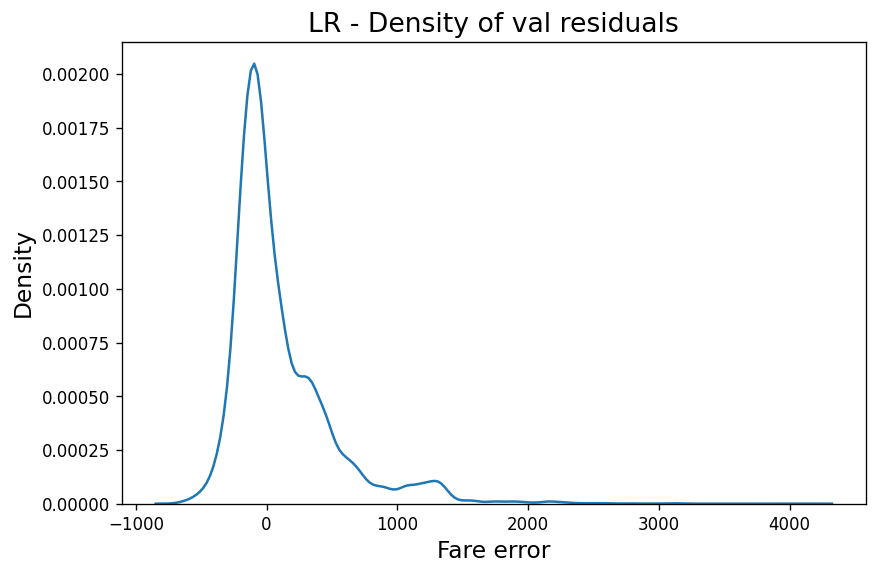

In [31]:
plt.figure(figsize = (8, 5), dpi = 120)
sns.kdeplot(
    val_df['total_fare'] - val_df['pred_fare']
)
plt.title("LR - Density of val residuals", fontsize = 16)
plt.xlabel("Fare error", fontsize = 14)
plt.ylabel("Density", fontsize = 14)
plt.show()

### Metrics

In [32]:
print_metrics(
    train_df['total_fare'], train_df['pred_fare'],
    label = 'Train - LR'
)

print_metrics(
    val_df['total_fare'], val_df['pred_fare'],
    label = 'Val - LR'
)

Train - LR
RMSE: 384.2769
MAE: 230.0007
R2: 31.420%

Val - LR
RMSE: 406.9771
MAE: 259.9644
R2: 31.796%



### Feature importances

In [33]:
pl.DataFrame({
    "Feature": best_model['ridge'].feature_names_in_,
    "Coef": best_model['ridge'].coef_
}).sort("Coef")

Feature,Coef
str,f64
"""ohe__destination_id_1""",-0.133762
"""ohe__destination_id_2""",-0.101128
"""scaler__flt_departure_week""",-0.059011
"""scaler__days_since_start""",-0.058793
"""ohe__destination_id_6""",-0.053606
"""ohe__destination_id_5""",-0.045207
"""scaler__days_till_flight""",-0.023113
"""ohe__origin_id_3""",-0.014393
"""ohe__carrier_U3""",-0.002227
